# Download Required Data Files

In [1]:
import requests

filename = 'data-week-14.zip'
url = f'https://d17lzt44idt8rf.cloudfront.net/{filename}'
response = requests.get(url)

# Make sure the request was successful
if response.status_code == 200:

  # Write the content to a file
  with open(filename, 'wb') as f:
      f.write(response.content)

In [14]:
!unzip $filename

Archive:  data-week-14.zip
   creating: 00_raw_data/
  inflating: 00_raw_data/hdb_facilities_distance.csv  
  inflating: 00_raw_data/hdb_resale_w_info.csv  


<!--TABLE OF CONTENTS-->
# Table of Contents:
- [0. Functions used in this Notebook](#0.-Functions-used-in-this-Notebook)
- [1. K-Means Clustering](#1.-K-Means-Clustering)
  - [1.1 Exploratory Data Analysis (EDA)](#1.1-Exploratory-Data-Analysis-(EDA))
  - [1.2 Preprocessing](#1.2-Preprocessing)
  - [1.3 Selecting the Number of Clusters](#1.3-Selecting-the-Number-of-Clusters)
  - [1.4 Create the Clusters](#1.4-Create-the-Clusters)
  - [1.5 Understand the Clusters](#1.5-Understand-the-Clusters)
- [2. Principal Component Analysis (PCA)](#2.-Principal-Component-Analysis-(PCA))
  - [2.1 Exploratory Data Analysis (EDA)](#2.1-Exploratory-Data-Analysis-(EDA))
  - [2.2 Preprocessing](#2.2-Preprocessing)
  - [2.3 Selecting the Number of Components](#2.3-Selecting-the-Number-of-Components)
  - [2.4 Create the Components](#2.4-Create-the-Components)
  - [2.5 Understand the Components](#2.5-Understand-the-Components)
- [3. Appendix](#3.-Appendix)
  - [3.1 Elbow Method: Choosing the Numbre of Cluster](#3.1-Elbow-Method:-Choosing-the-Numbre-of-Cluster)
  - [3.2 Variance Explained: Quality of K-means Clusters](#3.2-Variance-Explained:-Quality-of-K-means-Clusters)

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Settings for Matplotlib (& Seaborn)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Import libraries for charting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Set the size of charts
plt.rc('figure', figsize=(16,9))
sns.set_context(context={'figure.figsize': (16,9)})

# 0. Functions used in this Notebook

In [5]:
from scipy.spatial.distance import pdist

In [6]:
from sklearn.cluster import KMeans

In [7]:
def generate_elbow_method_viz(df_input, max_k=5):
    x = df_input
    wcss = []
    for i in range(1, max_k+1):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(x)
        wcss.append(kmeans.inertia_)

    # Calculate variance explained
    tss = sum(pdist(x)**2)/x.shape[0]
    bss = tss-wcss
    var_explained = bss/tss*100


    # Plot Elbow: dimishing sum of squared distances
    plt.figure(figsize=(16,9))

    ax = plt.subplot(1, 2, 1)
    ax.set_xticks(range(1, max_k+1, 1))
    plt.plot(range(1, max_k+1), wcss, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow Method')

    # Plot Elbow: increasing variance explained
    bx = plt.subplot(1, 2, 2)
    bx.set_xticks(range(1, max_k +1, 1))
    plt.plot(range(1, max_k+1), var_explained, 'b*-')
    plt.grid(True)
    plt.xticks = range(1, max_k+1)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Variance Explained')

    plt.tight_layout()

In [8]:
from sklearn.decomposition import PCA

In [9]:
def generate_pca_varexplained_viz(df_input, n_components=5):
    pca = PCA(n_components=n_components)
    pca.fit(df_input)
    cumulative_var_explained = np.cumsum(pca.explained_variance_ratio_)

    ax = plt.subplot()
    plt.bar(x=np.arange(1, n_components+1), height=cumulative_var_explained)
    ax.set_xticks(range(1, n_components +1, 1))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')

# 1. K-Means Clustering

## 1.1 Exploratory Data Analysis (EDA)


🔷**TASK**

> Read the csv file **hdb_resale_w_info** into a variable **df**

In [17]:
df = pd.read_csv('00_raw_data/hdb_resale_w_info.csv')

<ipython-input-17-30601ee0cfdf>:1: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('00_raw_data/hdb_resale_w_info.csv')


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185968 entries, 0 to 185967
Data columns (total 45 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Tranc_YearMonth          185968 non-null  object 
 1   Tranc_Year               185968 non-null  int64  
 2   Tranc_Month              185968 non-null  int64  
 3   town                     185968 non-null  object 
 4   flat_type                185968 non-null  object 
 5   block                    185968 non-null  object 
 6   street_name              185968 non-null  object 
 7   storey_range             185968 non-null  object 
 8   floor_area_sqm           185968 non-null  float64
 9   flat_model               185968 non-null  object 
 10  lease_commence_date      185968 non-null  int64  
 11  resale_price             185968 non-null  float64
 12  floor_area_sqft          185968 non-null  float64
 13  price_per_sqft           185968 non-null  float64
 14  flat


🔷**TASK**

> Drop the following columns from the **df**. <br>
> The **df** used in the rest of the notebook should not contain these columns.<br>
> Notice this: If there is no instruction to ask you to store in a new variable, you should reassign the output back to the variable. In this case is **df**.


| Column Index | Field Name | Data Type |
|---|---|---|
| 31 | Latitude | float64 |
| 32 | Longitude | float64 |
| 33 | 1room_sold | int64  |
| 34 | 2room_sold  | int64 |
| 35 | 3room_sold | int64 |
| 36 | 4room_sold | int64  |
| 37 | 5room_sold  |  int64 |  
| 38 | exec_sold  | int64 |  
| 39 |  multigen_sold | int64 |  
| 40 | studio_apartment_sold | int64 |  

In [19]:
cols_to_drop = [
    'Latitude',
    'Longitude',
    '1room_sold',
    '2room_sold',
    '3room_sold',
    '4room_sold',
    '5room_sold',
    'exec_sold',
    'multigen_sold',
    'studio_apartment_sold'
]

df.drop(columns=cols_to_drop, inplace=True)


🔷**TASK**

> Filter to the rows which only contain trancsation in 2020


In [33]:
df['Tranc_Year'] = pd.to_datetime(df['Tranc_Year'], format='%Y')
df = df[df['Tranc_Year'].dt.year == 2020]


🔷**TASK**

> Filter to rows to contains these few **flat_type** only <br>
> | 1 ROOM | 2 ROOM | 3 ROOM | 4 ROOM | 5 Room |

In [34]:
allowed_flat_types = ['1 ROOM', '2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM']
df = df[df['flat_type'].isin(allowed_flat_types)]

In [35]:
df["flat_type"].value_counts()

4 ROOM    9650
5 ROOM    5984
3 ROOM    5387
2 ROOM     419
1 ROOM      10
Name: flat_type, dtype: int64

In [36]:
# Reset the index since we're only using the subset of original data for the rest of the notebook
df = df.reset_index(drop=True)

## 1.2 Preprocessing

In [37]:
features = [
    'age_approx',
    'floor_area_sqft',
    'price_per_sqft'
]

In [38]:
from sklearn.preprocessing import StandardScaler


🔷**TASK**

> Standardize the features and store the values into a new DataFrame **dff** <br>
> The new DataFrame should also have proper column names:<br>
> - **age_approx**|
> - **floor_area_sqft**
> - **price_per_sqft**

In [39]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler instance
scaler = StandardScaler()

# Standardize the selected features
scaled_features = scaler.fit_transform(df[features])

In [40]:
# Create a new DataFrame with the standardized values
dff = pd.DataFrame(scaled_features, columns=features)

In [41]:
dff.describe()

,age_approx,floor_area_sqft,price_per_sqft
count,2.145000e+04,2.145000e+04,2.145000e+04
mean,3.103035e-16,-2.111256e-15,-5.050803e-16
std,1.000023e+00,1.000023e+00,1.000023e+00
min,-1.534207e+00,-3.059125e+00,-2.001477e+00
25%,-1.123392e+00,-9.030422e-01,-6.521125e-01
50%,-2.788562e-02,-2.100822e-02,-2.458700e-01
75%,8.622135e-01,8.120239e-01,3.310627e-01
max,2.094658e+00,3.752137e+00,6.196934e+00


## 1.3 Selecting the Number of Clusters


🔷**TASK**

> Use the function **generate_elbow_method_viz** to generate the graph which can help you to decide on the number of clusters. <br>
> Caution: this cell will take a long time to run.

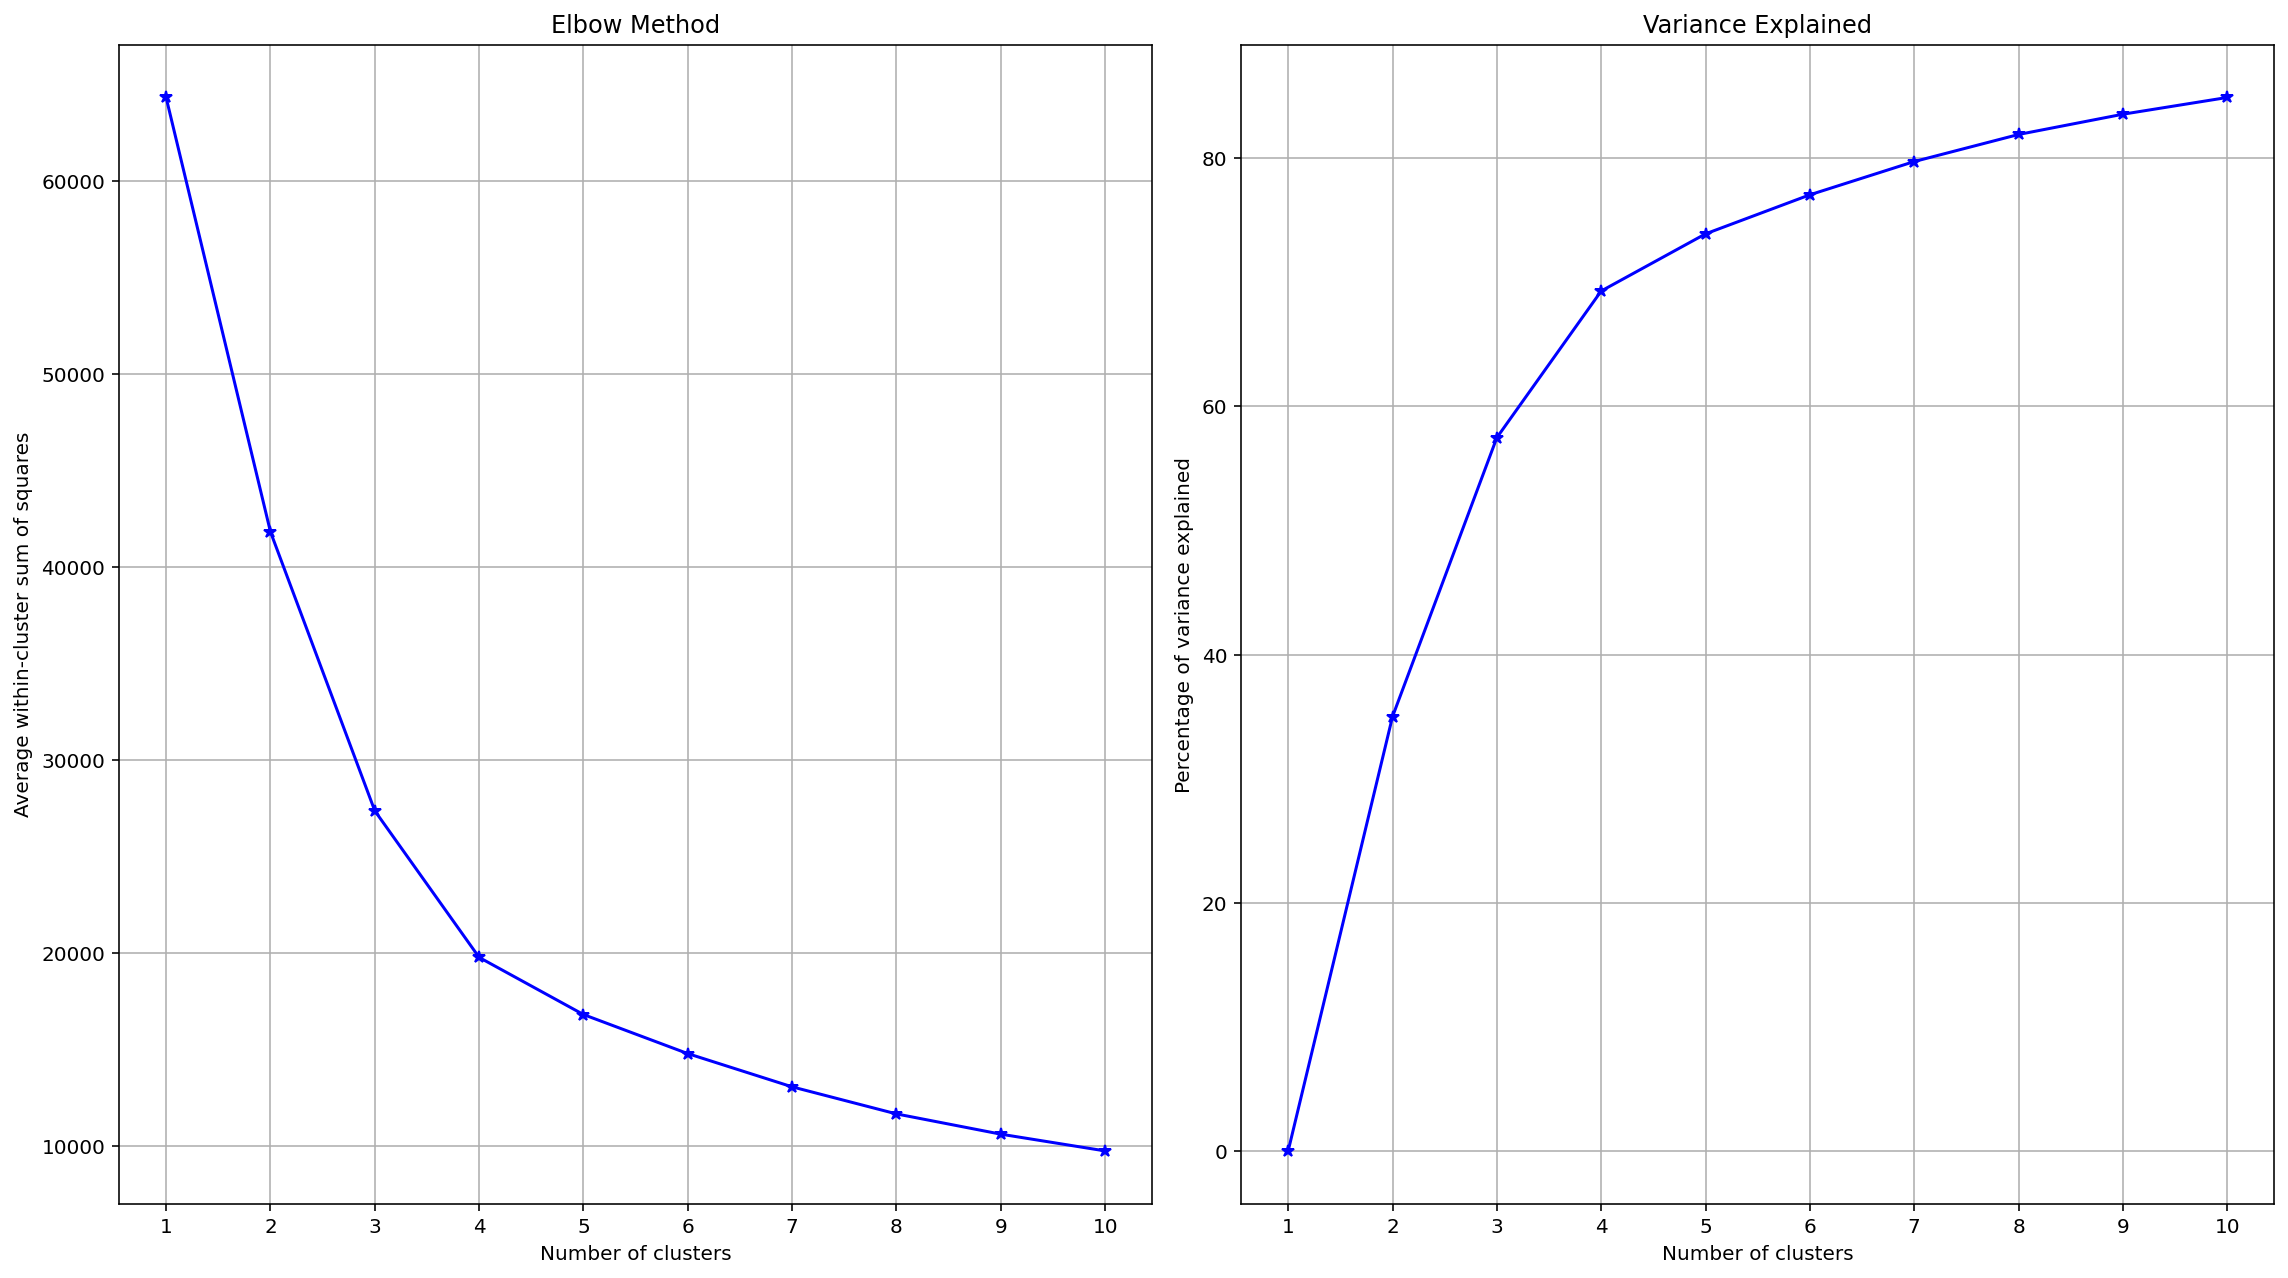

In [42]:
generate_elbow_method_viz(dff, max_k=10)

## 1.4 Create the Clusters


🔷**TASK**

> Instantiate, trainer, and generate the cluster for all data rows. <br>
> Then create a column in **df** to store the cluster being generated.

In [43]:
from sklearn.cluster import KMeans

In [45]:
# Instantiate (from Recipe)

from sklearn.cluster import KMeans

# Define the number of clusters
num_clusters = 5

# Instantiate the KMeans clustering algorithm
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)

# Train the KMeans algorithm on your data
kmeans.fit(dff)

# Generate cluster labels for all data rows
clusters = kmeans.predict(dff)

# Create a new column in df to store the cluster labels
df['Cluster'] = clusters

In [46]:
from sklearn.cluster import KMeans

# Define the number of clusters
num_clusters = 5

# Instantiate the KMeans clustering algorithm
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)

# Train the KMeans algorithm on your data
kmeans.fit(dff)

# Generate cluster labels for all data rows
clusters = kmeans.predict(dff)

# Create a new column in df to store the cluster labels
df['Cluster'] = clusters


In [47]:
# Insert the 'Cluster Number' into Original df
df['Cluster Number'] = clusters

In [48]:
df.head(10)

,Tranc_YearMonth,Tranc_Year,Tranc_Month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,...,year_completed,residential,commercial,postal,total_dwelling_units,age_approx,storey_range_midpoint,storey_relative,Cluster,Cluster Number
0,2020-01,2020-01-01,1,ANG MO KIO,3 ROOM,208,ANG MO KIO AVE 1,04 TO 06,73.0,New Generation,...,1975,Y,N,560208,153,45,5,0.416667,0,0
1,2020-01,2020-01-01,1,ANG MO KIO,3 ROOM,307C,ANG MO KIO AVE 1,19 TO 21,70.0,Model A,...,2010,Y,N,563307,230,9,20,0.952381,4,4
2,2020-01,2020-01-01,1,ANG MO KIO,3 ROOM,319,ANG MO KIO AVE 1,01 TO 03,73.0,New Generation,...,1976,Y,N,560319,194,44,2,0.166667,0,0
3,2020-01,2020-01-01,1,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,New Generation,...,1975,Y,N,560216,144,45,5,0.500000,0,0
4,2020-01,2020-01-01,1,ANG MO KIO,3 ROOM,556,ANG MO KIO AVE 10,07 TO 09,68.0,New Generation,...,1979,Y,N,560556,189,41,8,0.615385,0,0
5,2020-01,2020-01-01,1,ANG MO KIO,3 ROOM,536,ANG MO KIO AVE 10,10 TO 12,68.0,New Generation,...,1979,Y,N,560536,151,41,11,0.916667,0,0
6,2020-01,2020-01-01,1,ANG MO KIO,3 ROOM,560,ANG MO KIO AVE 10,04 TO 06,67.0,New Generation,...,1979,Y,Y,560560,190,41,5,0.384615,0,0
7,2020-01,2020-01-01,1,ANG MO KIO,3 ROOM,463,ANG MO KIO AVE 10,04 TO 06,82.0,New Generation,...,1979,Y,N,560463,256,41,5,0.384615,0,0
8,2020-01,2020-01-01,1,ANG MO KIO,3 ROOM,476,ANG MO KIO AVE 10,01 TO 03,67.0,New Generation,...,1979,Y,N,561476,166,42,2,0.153846,0,0
9,2020-01,2020-01-01,1,ANG MO KIO,3 ROOM,442,ANG MO KIO AVE 10,01 TO 03,67.0,New Generation,...,1978,Y,N,560442,215,42,2,0.166667,0,0


## 1.5 Understand the Clusters

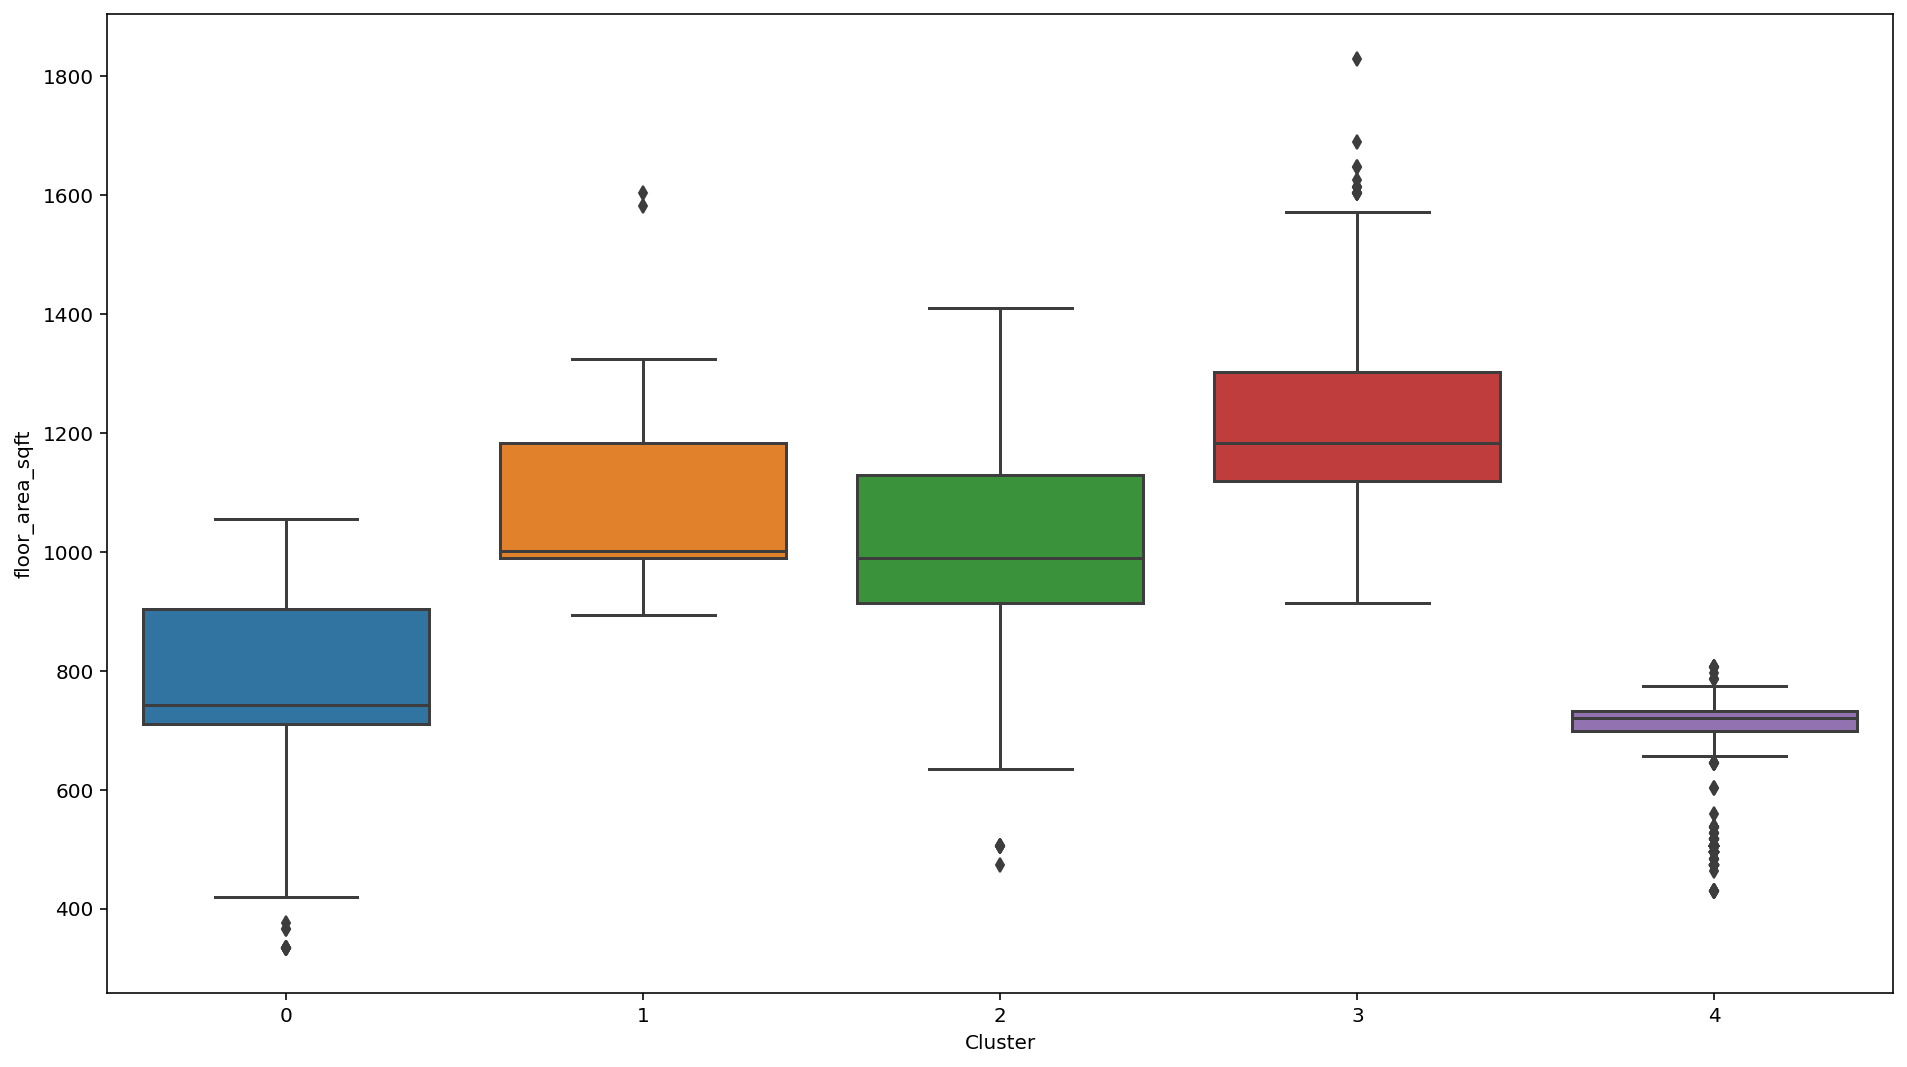

In [50]:
sns.boxplot('Cluster', 'floor_area_sqft', data=df)

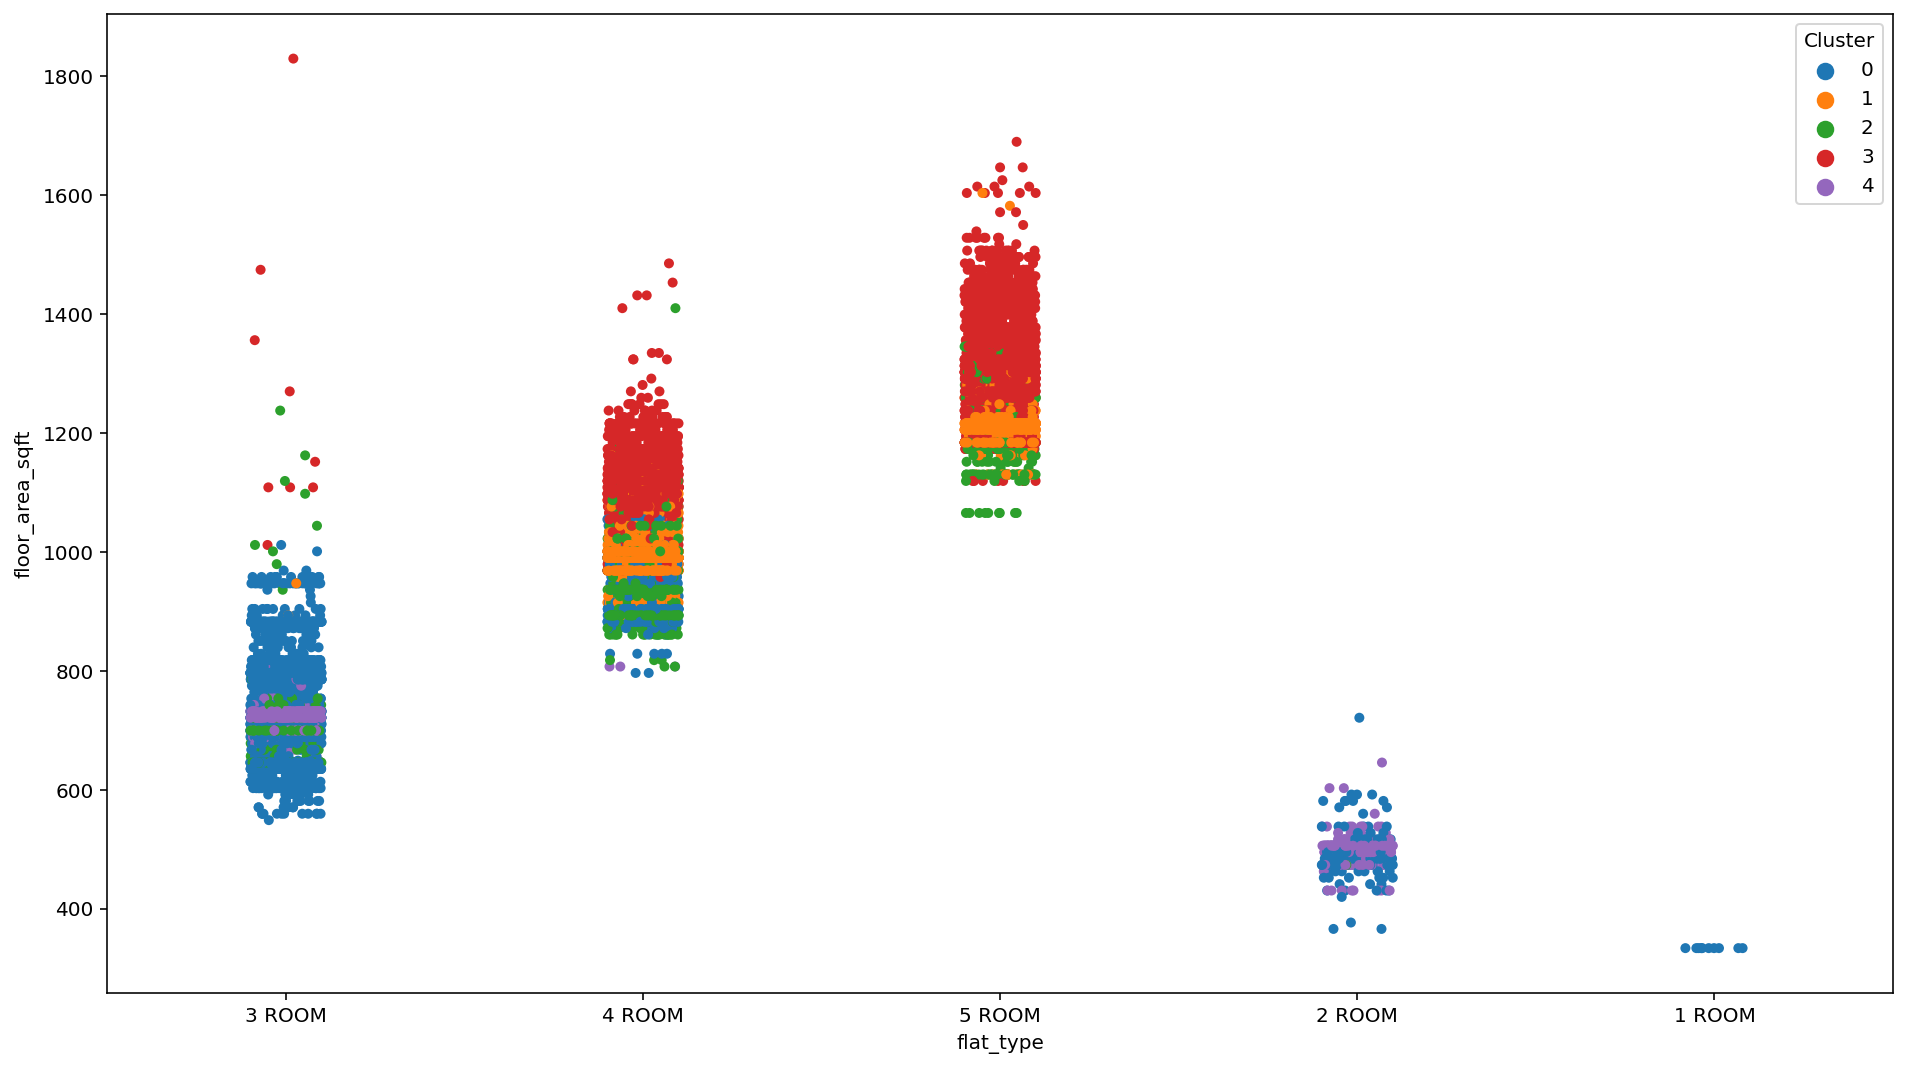

In [52]:
sns.stripplot(x='flat_type', y='floor_area_sqft', hue='Cluster', data=df)


🔷**TASK (OPTIONAL)**

> Use any methods/visualisations to help you understand the clusters.\
> Share your observations about the cluster in this jupyter notebook (after the methods/visualisations)

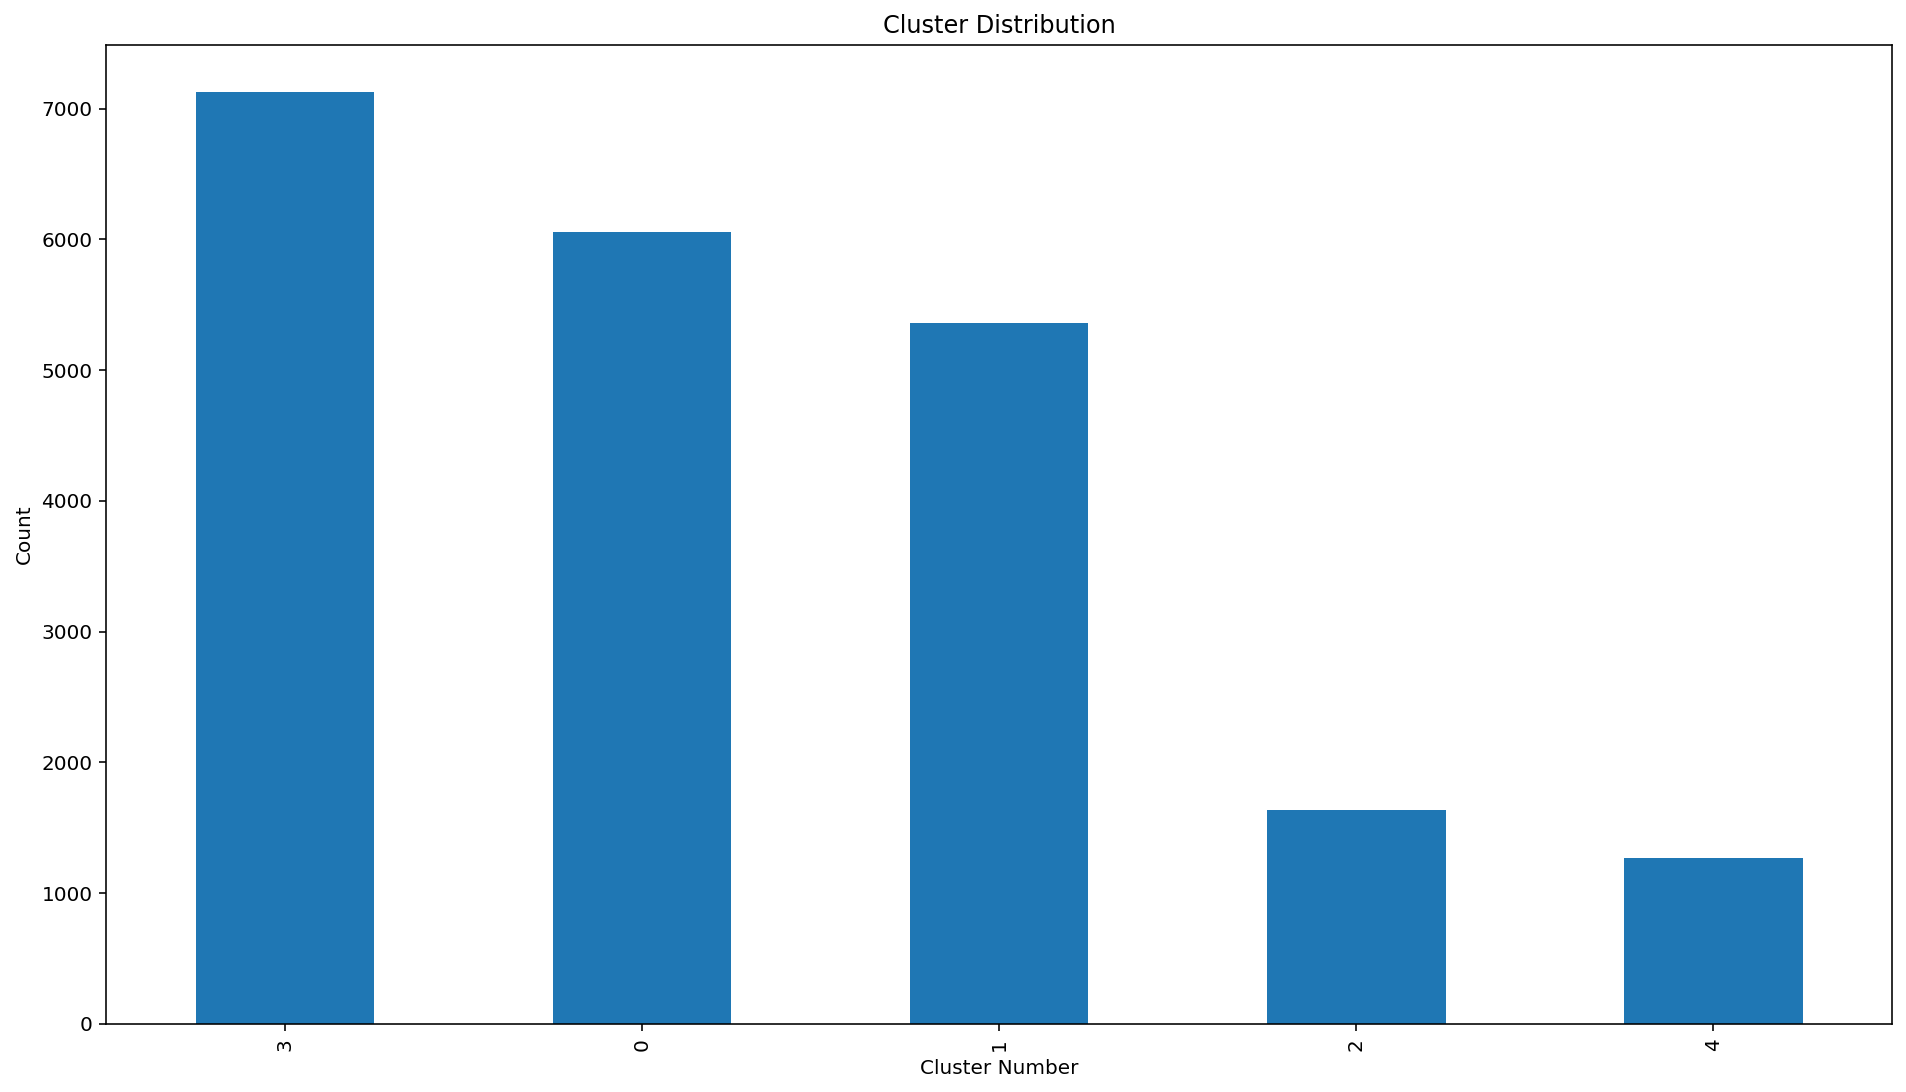

In [53]:
cluster_counts = df['Cluster Number'].value_counts()
cluster_counts.plot(kind='bar')
plt.xlabel('Cluster Number')
plt.ylabel('Count')
plt.title('Cluster Distribution')
plt.show()

In [54]:
cluster_profiles = df.groupby('Cluster Number')[features].mean()
print(cluster_profiles)

                age_approx  floor_area_sqft  price_per_sqft
Cluster Number                                             
0                40.708203       791.097974      395.689030
1                 8.510543      1052.737138      458.011895
2                11.958971       995.762918      758.535234
3                28.521745      1213.678048      371.217902
4                 6.644375       676.076240      487.424372


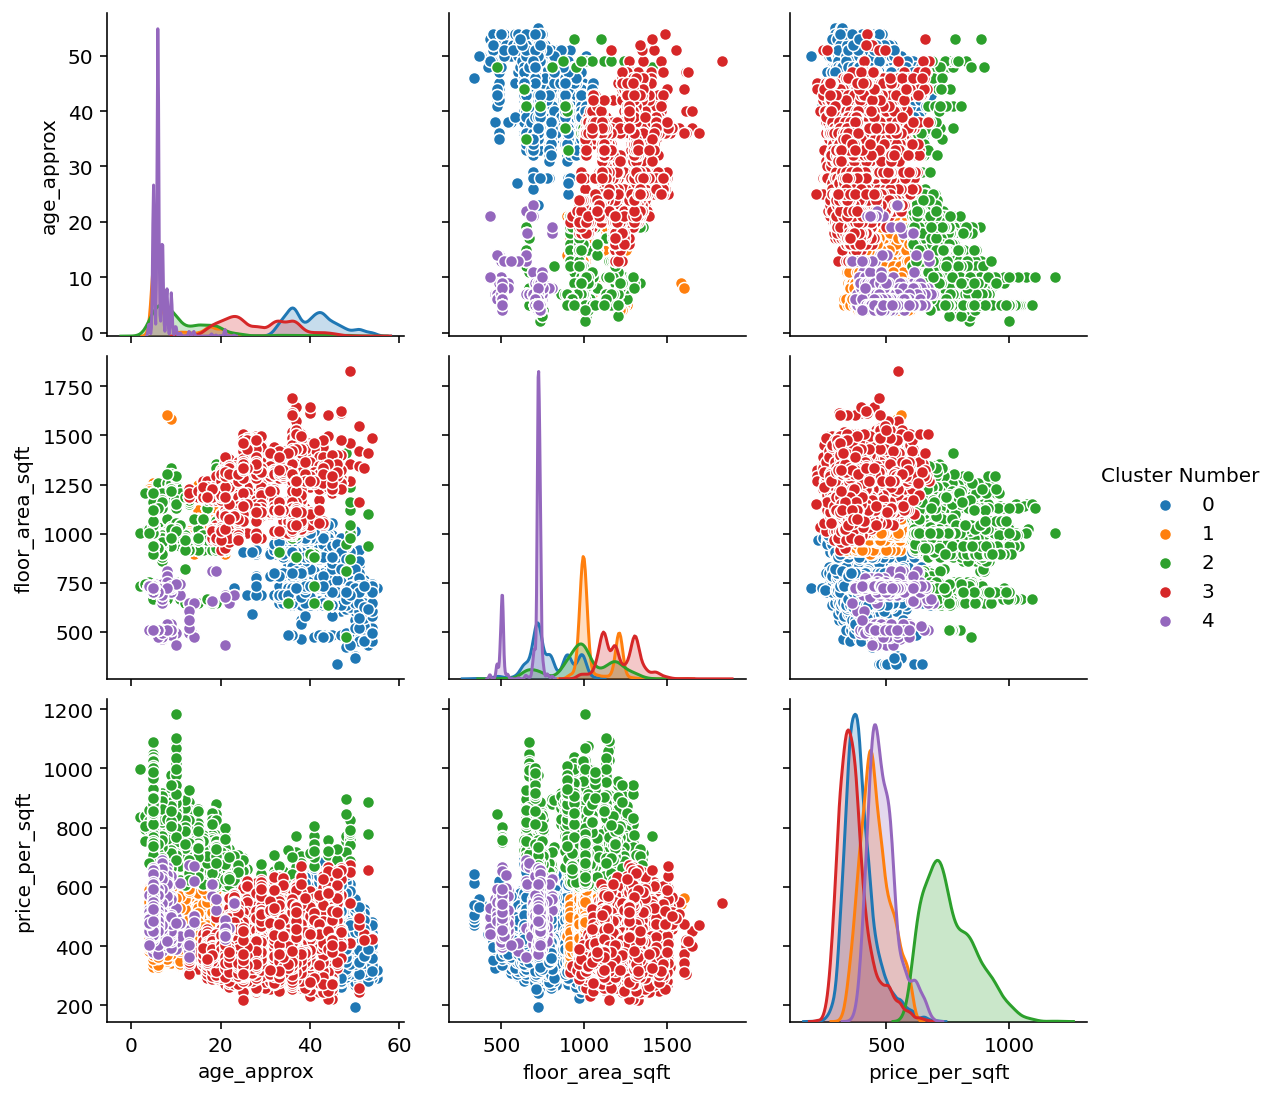

In [55]:
import seaborn as sns

sns.pairplot(df, vars=features, hue='Cluster Number')
plt.show()

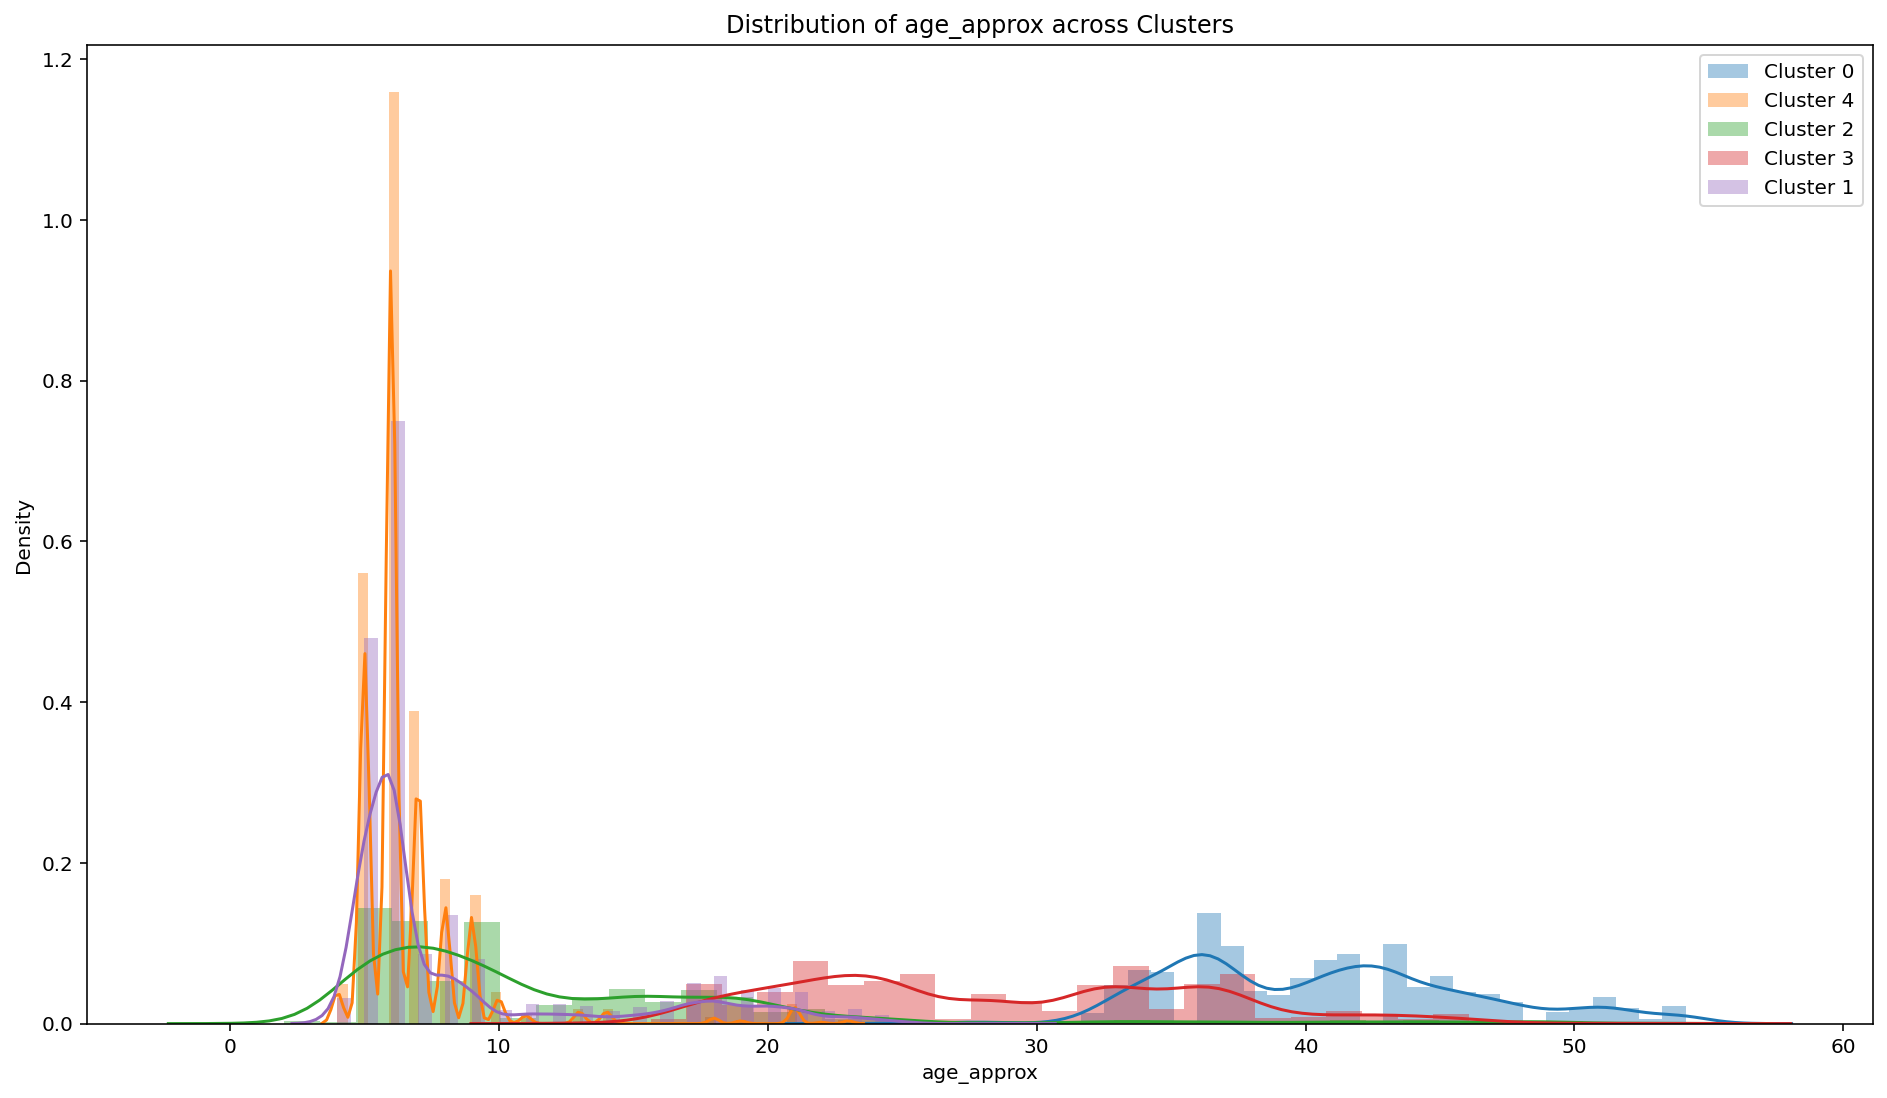

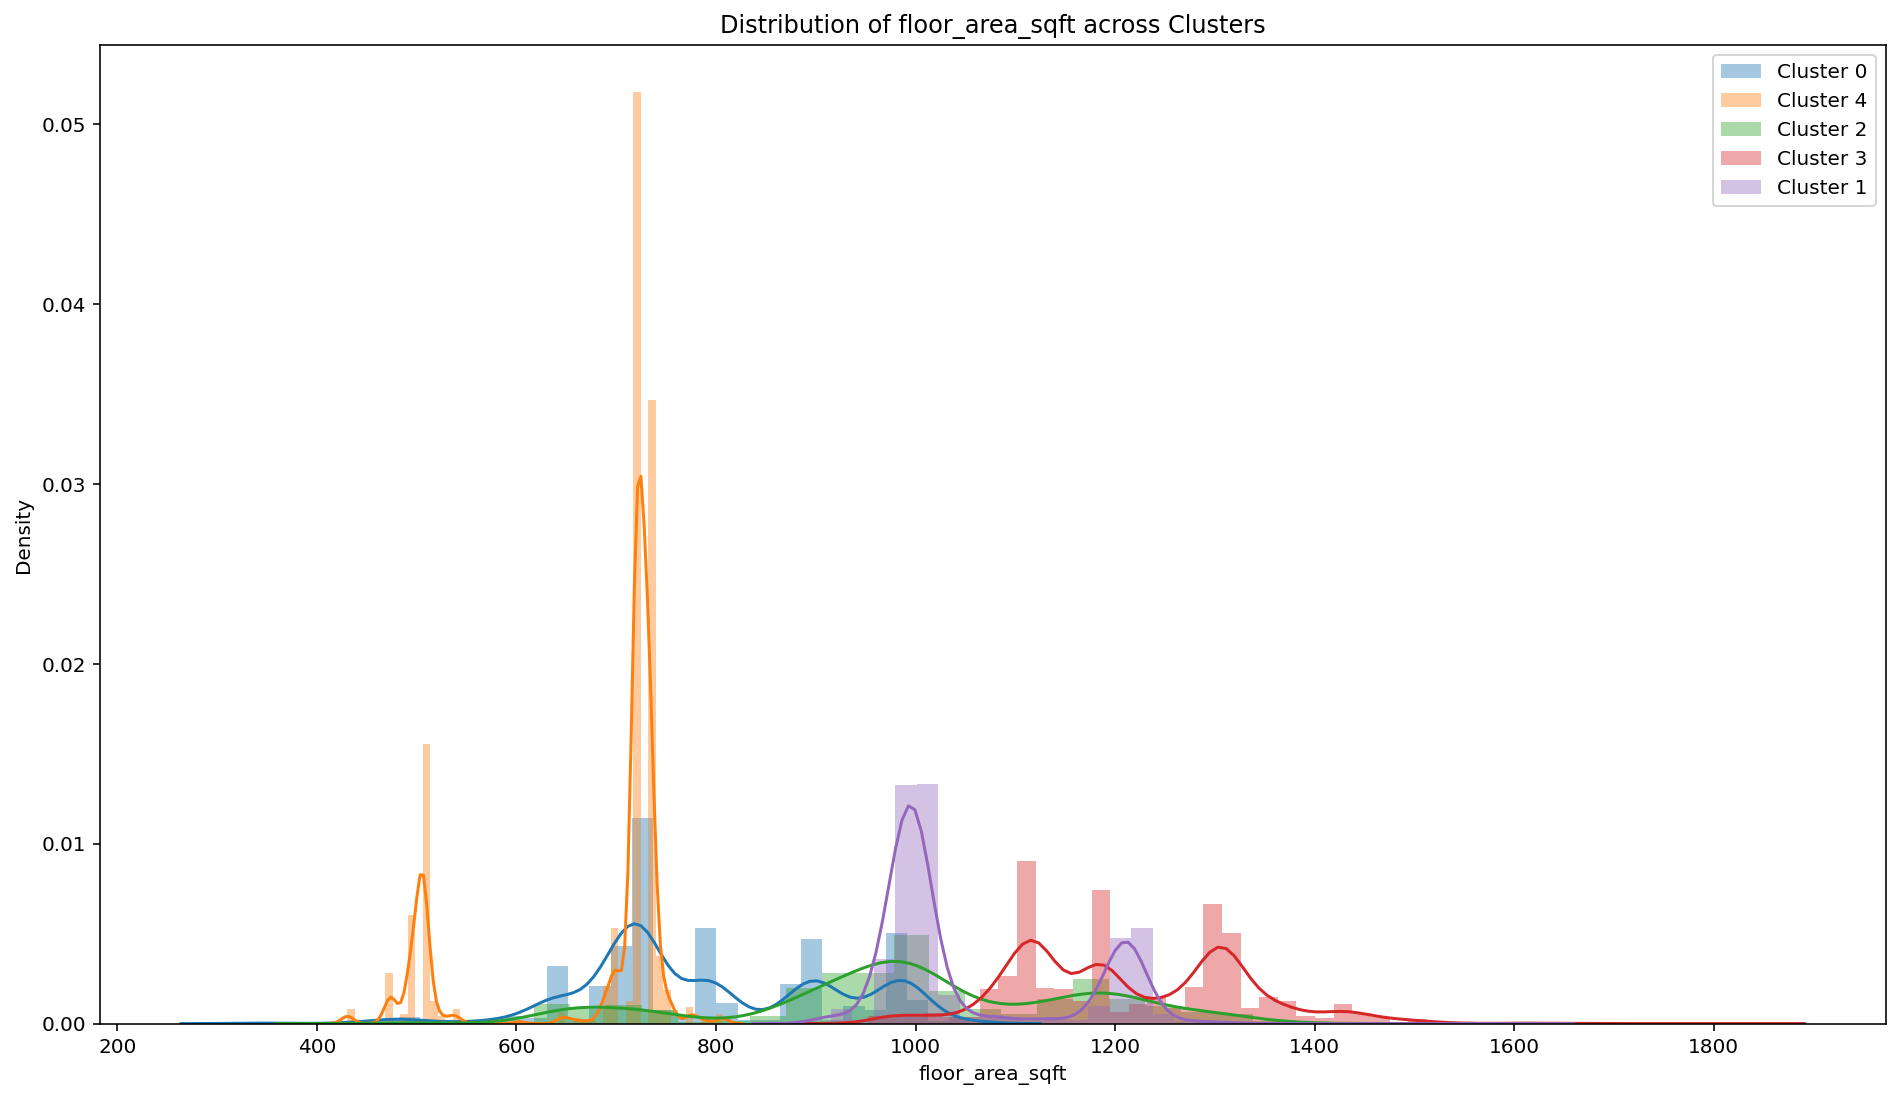

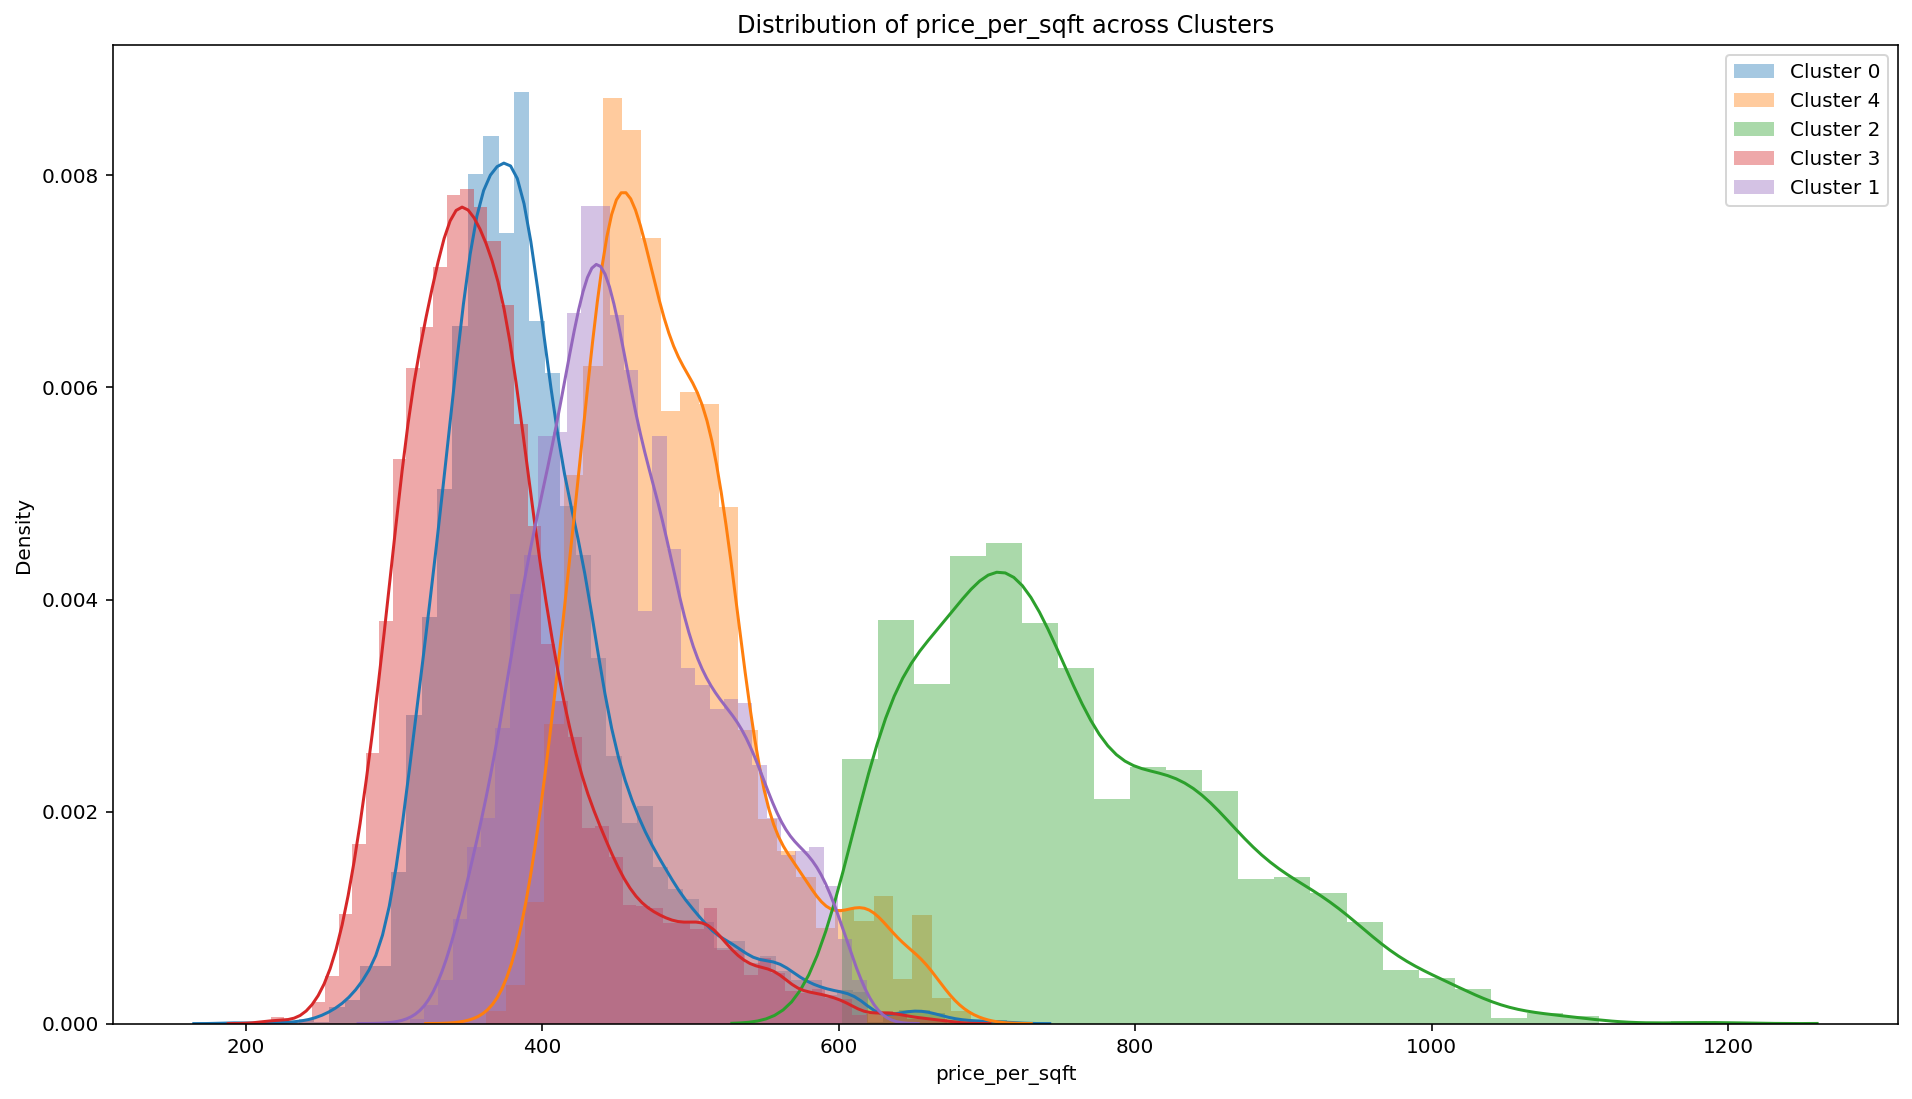

In [57]:
import seaborn as sns

for feature in features:
    plt.figure()
    for cluster in df['Cluster Number'].unique():
        sns.distplot(df[df['Cluster Number'] == cluster][feature], kde=True, label=f'Cluster {cluster}')
    plt.legend()
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.title(f'Distribution of {feature} across Clusters')
    plt.show()


---

# 2. Principal Component Analysis (PCA)

In [58]:
from sklearn.decomposition import PCA

## 2.1 Exploratory Data Analysis (EDA)

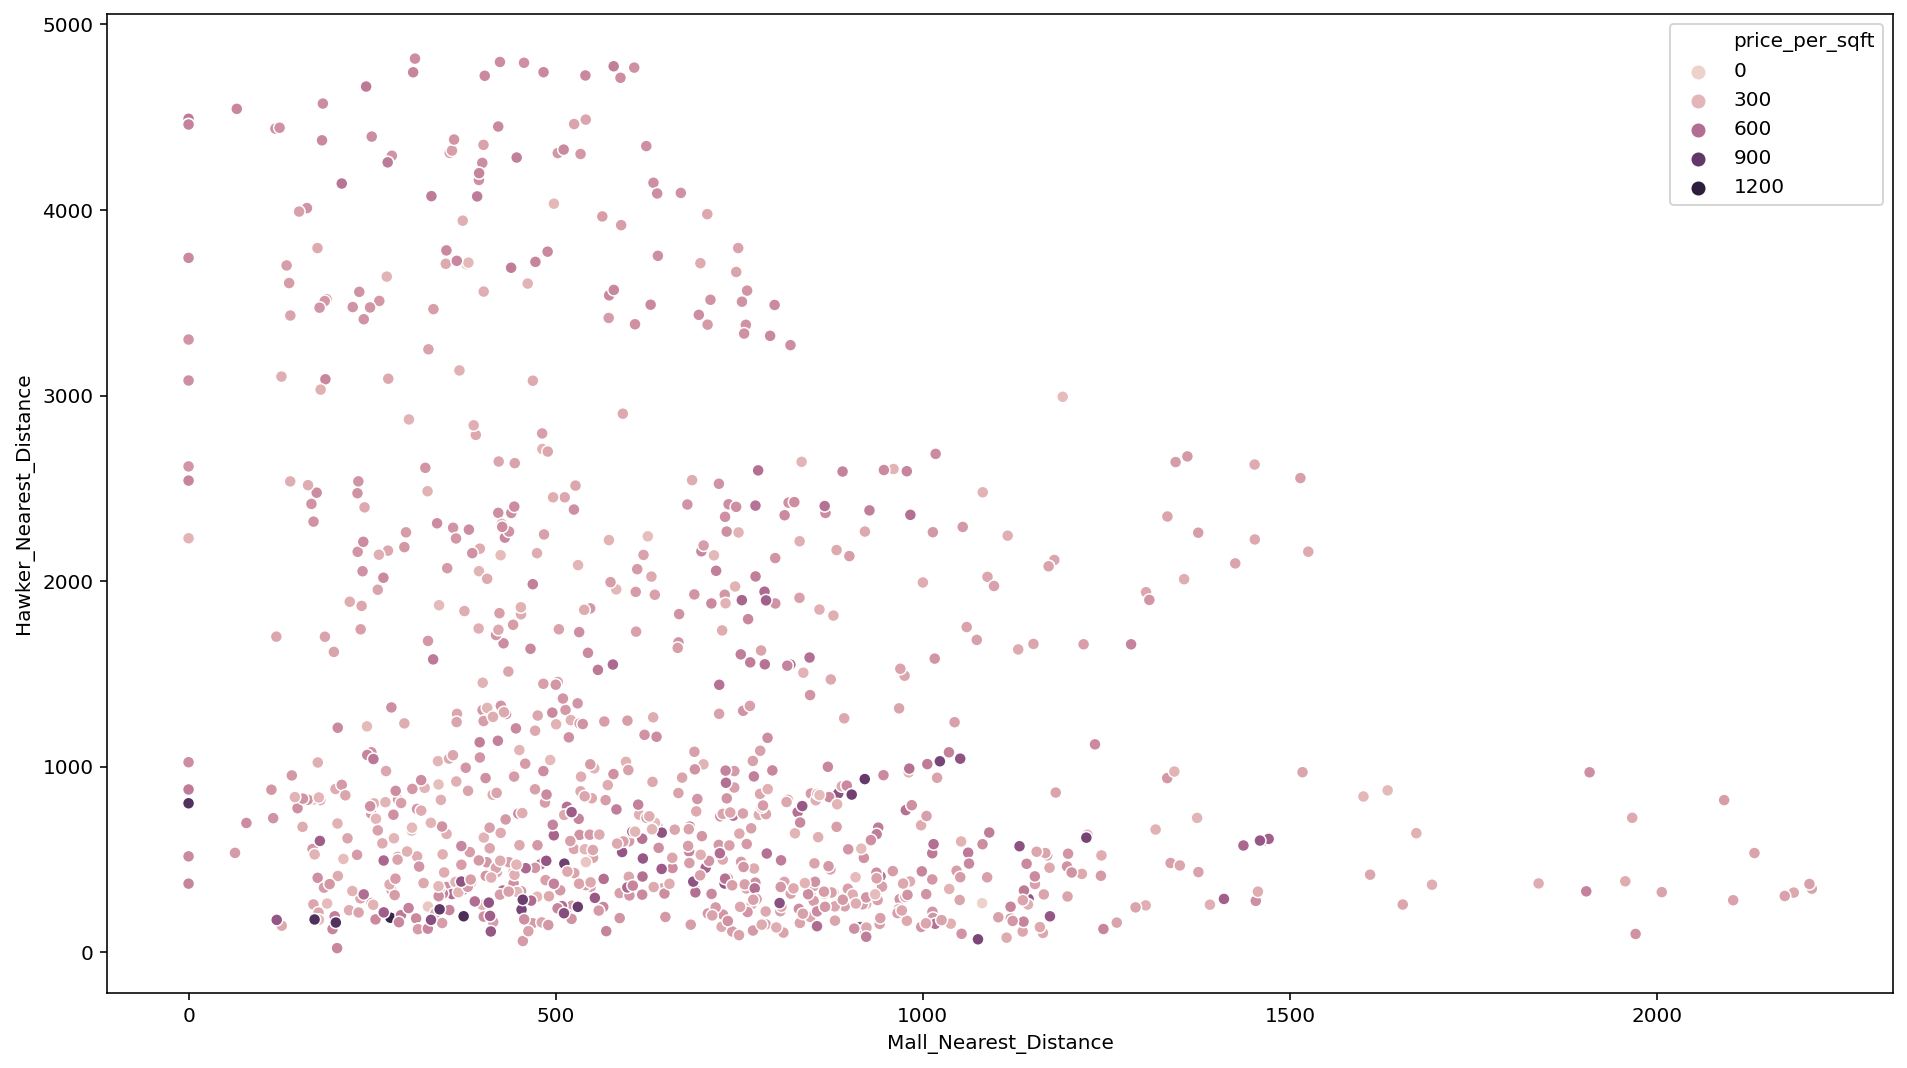

In [59]:
sns.scatterplot('Mall_Nearest_Distance', 'Hawker_Nearest_Distance', hue='price_per_sqft', data=df.sample(1000))

## 2.2 Preprocessing


🔷**TASK**

> Standardize the features and store the values into a new DataFrame **dff** <br>
> The new DataFrame should also have original column names.

In [61]:
features = ['Mall_Nearest_Distance',
    'Mall_Within_500m',
    'Mall_Within_1km',
    'Mall_Within_2km',
    'Hawker_Nearest_Distance',
    'Hawker_Within_500m',
    'Hawker_Within_1km',
    'Hawker_Within_2km',
]

In [62]:
from sklearn.preprocessing import StandardScaler

In [63]:
# Instantiate the scaler (from the 'Recipe')

# Define the features
features = ['Mall_Nearest_Distance', 'Mall_Within_500m', 'Mall_Within_1km', 'Mall_Within_2km',
            'Hawker_Nearest_Distance', 'Hawker_Within_500m', 'Hawker_Within_1km', 'Hawker_Within_2km']

# Instantiate the StandardScaler
scaler = StandardScaler()

In [64]:
# Standardize the features and store the values in a new DataFrame with original column names
dff = pd.DataFrame(scaler.fit_transform(df[features]), columns=features)

In [65]:
dff.describe()

,Mall_Nearest_Distance,Mall_Within_500m,Mall_Within_1km,Mall_Within_2km,Hawker_Nearest_Distance,Hawker_Within_500m,Hawker_Within_1km,Hawker_Within_2km
count,2.145000e+04,2.145000e+04,2.145000e+04,2.145000e+04,2.145000e+04,2.145000e+04,2.145000e+04,2.145000e+04
mean,2.339698e-16,-7.934704e-16,-3.395367e-17,-7.857584e-16,6.076905e-16,-8.889890e-15,3.604511e-15,5.722281e-16
std,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00
min,-1.772529e+00,-6.883510e-01,-1.257480e+00,-1.470791e+00,-1.081055e+00,-6.055504e-01,-8.044754e-01,-8.964251e-01
25%,-7.217813e-01,-6.883510e-01,-5.372796e-01,-6.124694e-01,-7.487106e-01,-6.055504e-01,-8.044754e-01,-6.494649e-01
50%,-1.556511e-01,-6.883510e-01,1.829208e-01,-4.025508e-02,-3.925996e-01,-6.055504e-01,-2.068651e-01,-4.025048e-01
75%,5.655657e-01,7.350683e-01,1.829208e-01,2.458521e-01,5.058450e-01,7.287132e-01,3.907452e-01,8.322961e-01
max,7.931586e+00,7.852165e+00,9.545527e+00,1.083182e+01,2.973670e+00,6.065767e+00,4.574017e+00,3.795818e+00


## 2.3 Selecting the Number of Components

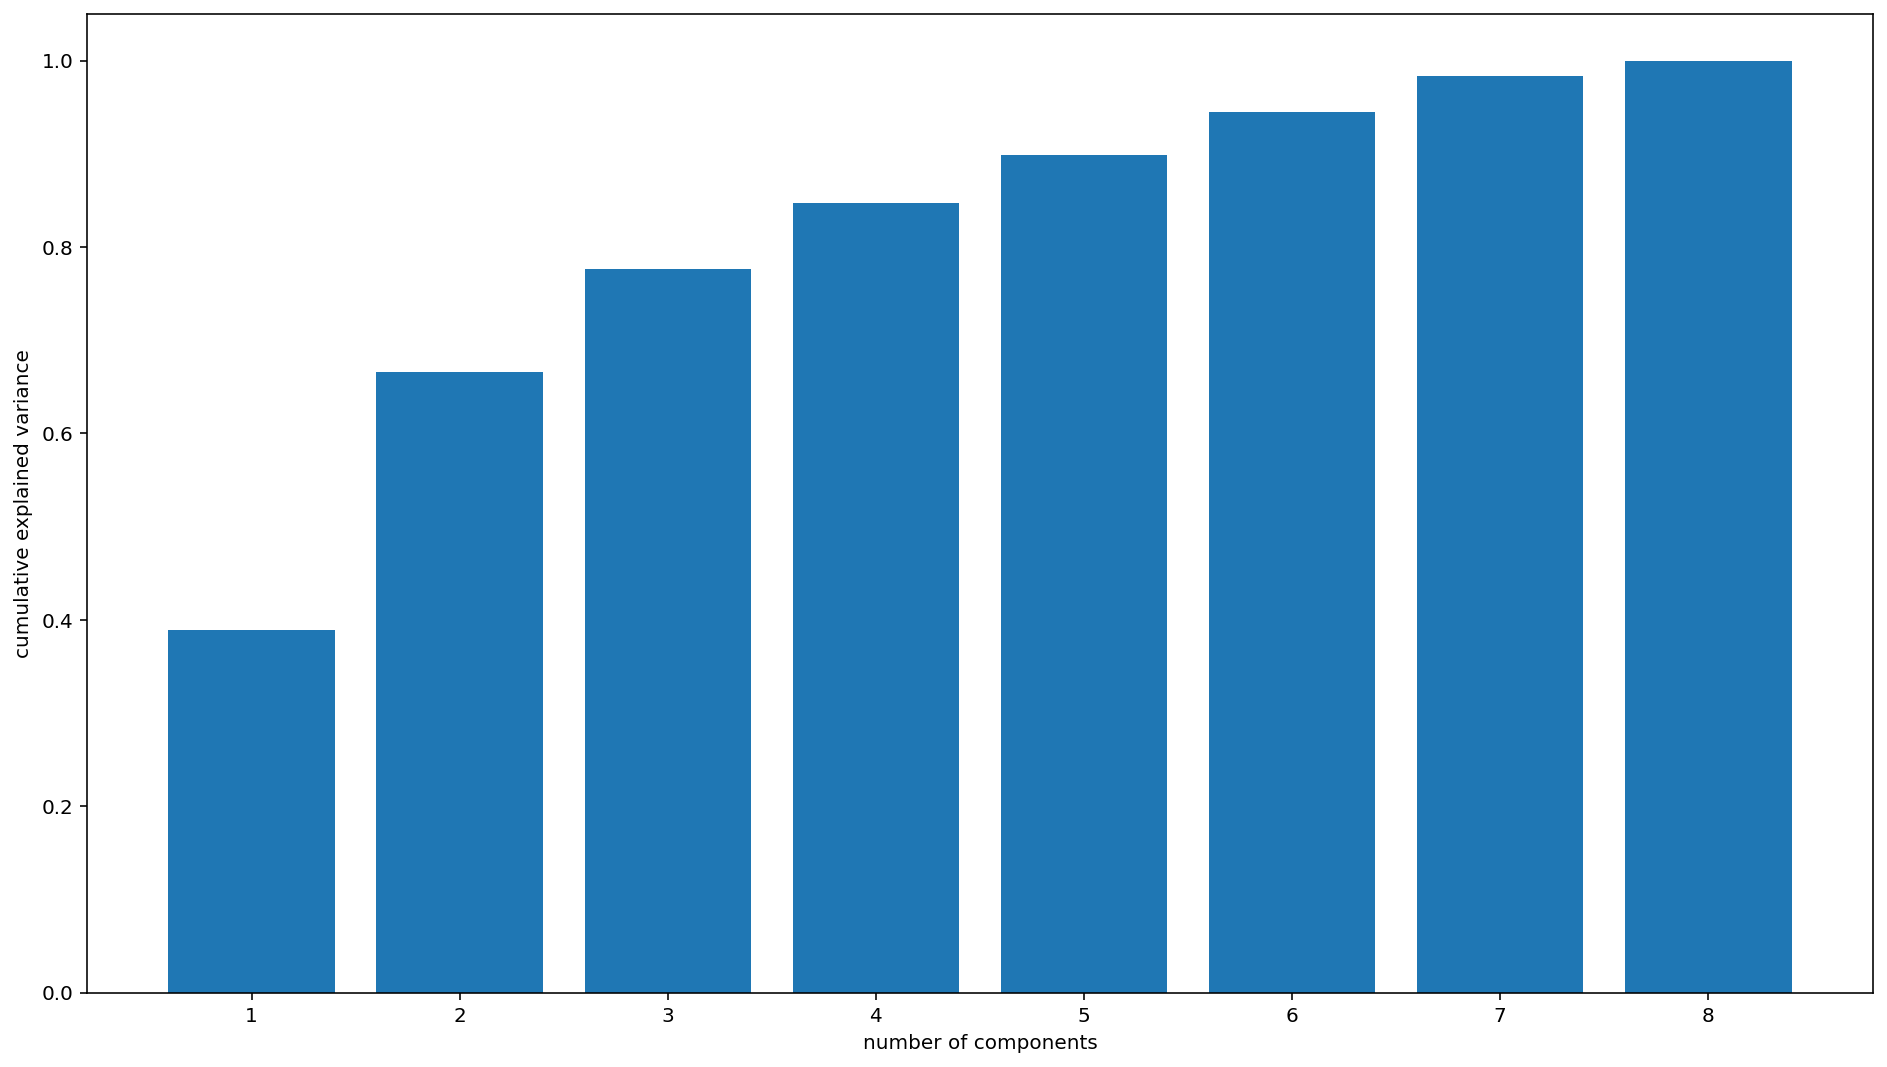

In [66]:
generate_pca_varexplained_viz(dff, 8)

## 2.4 Create the Components

In [67]:
n_components = 2

# Instantiate the PCA model
pca = PCA(n_components=n_components)

# Train the PCA model on the standardized data
components = pca.fit_transform(dff)

In [68]:
# Transfrom the components from n_arrays to DataFrame
cols_name = ['pc_' + str(col) for col in range(1, n_components+1)]
components = pd.DataFrame(components, columns=cols_name)

## 2.5 Understand the Components

In [69]:
df_mapping = pd.DataFrame(pca.components_.T, columns=['pc_1', 'pc_2'], index=features)
np.abs(df_mapping).style.background_gradient(sns.dark_palette("green", as_cmap=True))

,pc_1,pc_2
Mall_Nearest_Distance,0.165752,0.510108
Mall_Within_500m,0.053904,0.540686
Mall_Within_1km,0.005463,0.555266
Mall_Within_2km,0.154386,0.359458
Hawker_Nearest_Distance,0.435803,0.028615
Hawker_Within_500m,0.474561,0.067781
Hawker_Within_1km,0.521032,0.067114
Hawker_Within_2km,0.509066,0.000988


In [70]:
df['price_per_sqft_exp'] = df['price_per_sqft'] >= 800
df['price_per_sqft_exp'].value_counts()

False    20932
True       518
Name: price_per_sqft_exp, dtype: int64

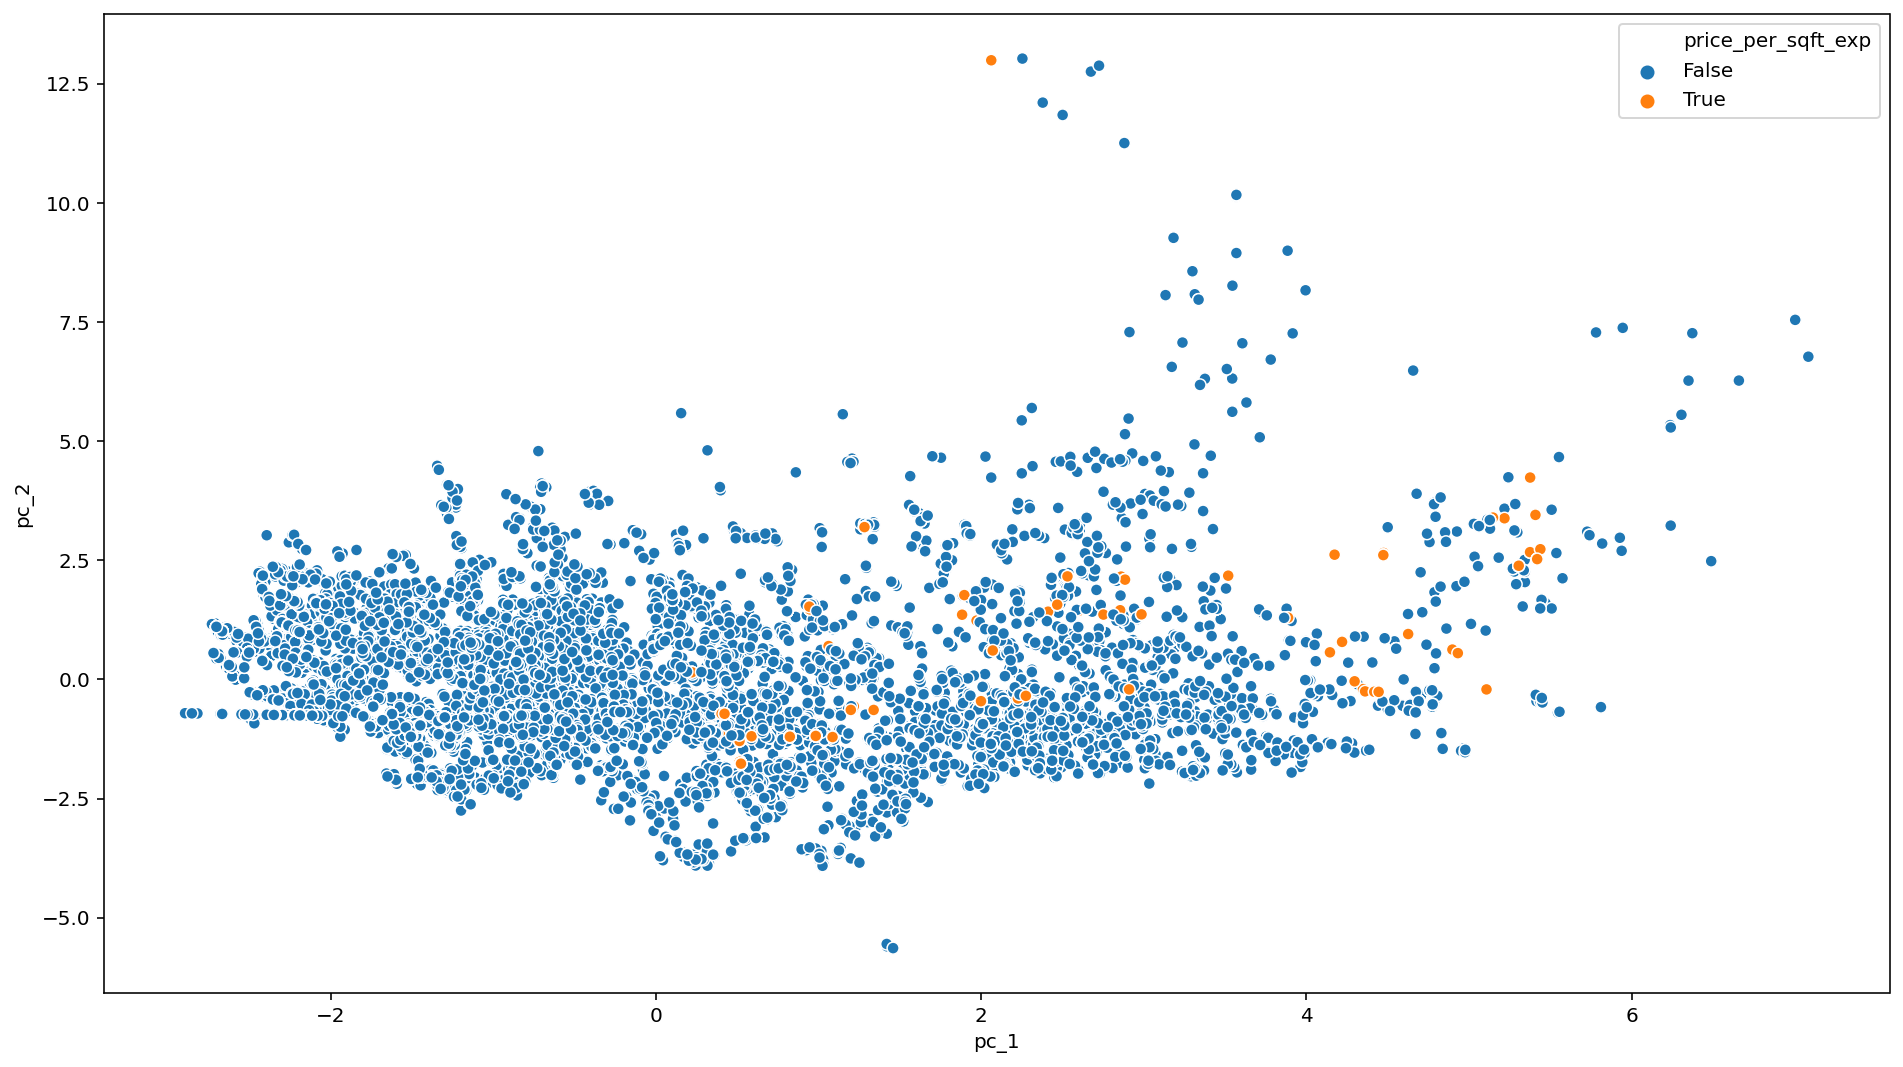

In [71]:
sns.scatterplot(x=components['pc_1'], y=components['pc_2'], hue=df['price_per_sqft_exp'])

## ⚠️ End of Practical Tasks in this Notebook

---

# 3. Appendix

## 3.1 Elbow Method: Choosing the Numbre of Cluster

This method draws the graph the relationship between the number of clusters and Within Cluster Sum of Squares (WCSS) then we select the number of clusters where the change in WCSS begins to flat out.

WCSS is defined as the sum of the squared distance between each member of the cluster and its centroid. In Scikit-Learn, it can be accessed from model's instance.inertia_


$$ WSS = \sum^{m}_{i=1} (x_i - c_i)^2$$


![](_resources/wcss_explained2.png)

## 3.2 Variance Explained: Quality of K-means Clusters

The quality of a k-means partition is found by calculating the percentage of the Total Sum of Squares (TSS) “explained” by the clusters using the following formula:

<br>
$$\frac{TSS - WCSS}{TSS} * 100\%$$
<br>

The higher the percentage, the better the score (and thus the quality).

[Reference: A complete guide to clustering analysis](https://statsandr.com/blog/clustering-analysis-k-means-and-hierarchical-clustering-by-hand-and-in-r/)

## 3.3 Standardization

When to use **StandardScaler**? Distance-based algoritmns, such as:
- Before K-Nearest Neighbor (KNN)
- Before Support Vector Machine (SVM)
- Before Clustering (K-Mean)

### Example Codes

In [74]:
#original code error
#from sklearn.preprocessing import StandardScaler

# Transform the numerical features and store into the new variable 'arrays_of_transformed_values'
#std_scaler = StandardScaler()
#arrays_of_transformed_values = std_scaler.fit_transform(df[features_numeric])

# Convert the new variable into Data Frame with the column names
#df_transformed_values = pd.DataFrame(arrays_of_transformed_values)

# Create Column Names, so that now each column is '[original_colname] + _std'
# For example, 'age' -> 'age_std'
#new_colnames = [str(c) + '_std' for c in features_numeric]

# Assign the new column names
#df_transformed_values.columns = new_colnames

#df = pd.concat([df, df_transformed_values], axis=1, sort=False)


#amended code

from sklearn.preprocessing import StandardScaler

# Define the numeric features
features_numeric = ['age_approx', 'floor_area_sqft', 'price_per_sqft']

# Transform the numerical features and store them in the new variable 'arrays_of_transformed_values'
std_scaler = StandardScaler()
arrays_of_transformed_values = std_scaler.fit_transform(df[features_numeric])

# Convert the new variable into a DataFrame with the column names
df_transformed_values = pd.DataFrame(arrays_of_transformed_values, columns=[f + '_std' for f in features_numeric])

# Concatenate the transformed values DataFrame with the original DataFrame
df = pd.concat([df, df_transformed_values], axis=1)



### Demystifying "Standard Scaler "

> Replicating the StandardScaler without using package (For your info: What StandardScaler does)

In [75]:
list_of_transformed_values = []

for col in features_numeric:
    mean = df[col].mean()
    std = df[col].std()

    newcol =  (df[col] - mean) / std
    list_of_transformed_values.append(newcol)


df_manual = pd.DataFrame(list_of_transformed_values)
df_manual = df_manual.transpose()
df_manual.head(10)

,age_approx,floor_area_sqft,price_per_sqft
0,1.409934,-1.001023,-0.818031
1,-1.054899,-1.148025,1.551058
2,1.341466,-1.001023,-1.186322
3,1.409934,-1.001023,-0.660192
4,1.136064,-1.246026,-1.121329
5,1.136064,-1.246026,-0.443550
6,1.136064,-1.295027,-0.854938
7,1.136064,-0.560016,-0.786848
8,1.204531,-1.295027,-0.682964
9,1.204531,-1.295027,-0.935193
